[nltk_data] Downloading package stopwords to
[nltk_data]     /home/golopes/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Epoch 1/30
2/2 - 5s - loss: 337.7437 - accuracy: 0.1000 - val_loss: 285.1597 - val_accuracy: 0.5556 - 5s/epoch - 3s/step
Epoch 2/30
2/2 - 0s - loss: 277.0453 - accuracy: 0.2000 - val_loss: 234.2924 - val_accuracy: 0.5556 - 389ms/epoch - 195ms/step
Epoch 3/30
2/2 - 0s - loss: 237.6317 - accuracy: 0.2000 - val_loss: 206.8042 - val_accuracy: 0.4444 - 325ms/epoch - 163ms/step
Epoch 4/30
2/2 - 0s - loss: 208.7344 - accuracy: 0.1800 - val_loss: 198.3754 - val_accuracy: 0.4444 - 289ms/epoch - 144ms/step
Epoch 5/30
2/2 - 0s - loss: 194.7728 - accuracy: 0.2000 - val_loss: 192.7754 - val_accuracy: 0.6667 - 300ms/epoch - 150ms/step
Epoch 6/30
2/2 - 0s - loss: 188.8057 - accuracy: 0.2800 - val_loss: 188.3477 - val_accuracy: 0.6667 - 314ms/epoch - 157ms/step
Epoch 7/30
2/2 - 0s - loss: 184.0455 - accuracy: 0.2800 - val_loss: 184.6145 - val_accuracy: 0.6667 - 319ms/epoch - 160ms/step
Epoch 8/30
2/2 - 0s - loss: 180.2525 - accuracy: 0.2800 - val_loss: 181.2928 - val_accuracy: 0.6667 - 304ms/epoch - 1

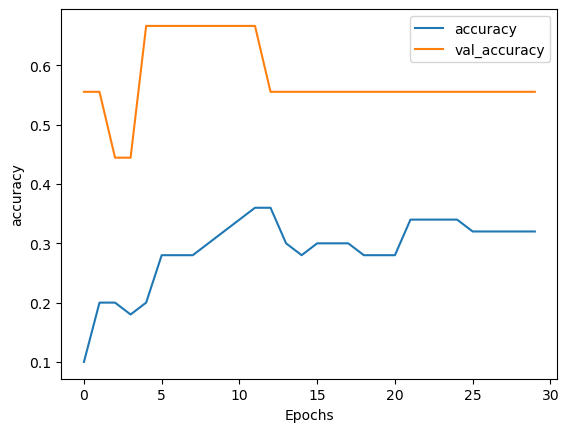

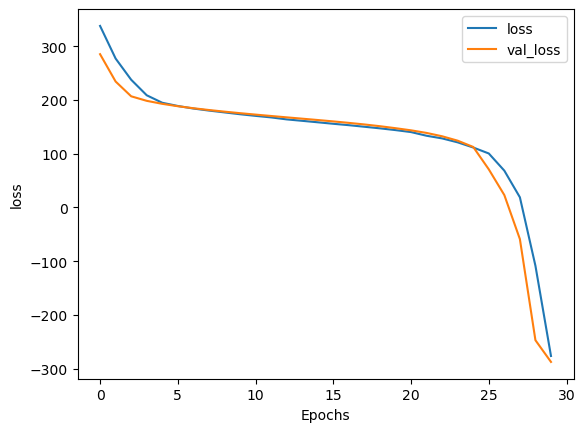

In [3]:
import tensorflow as tf
from tensorflow import keras
import csv
import numpy as np
import matplotlib.pyplot as plt
import re
import nltk
nltk.download('stopwords') # install NLTK data to home user directory
from nltk.corpus import stopwords
import unidecode

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@;]')
BAD_SYMBOLS_RE = re.compile('[^a-z 0-9 #+_]')
STOPWORDS = set(stopwords.words('english'))
STOPWORDS_RE = re.compile(r"\b(" + "|".join(STOPWORDS) + ")\\W")

def text_prepare(text):
    """
        text: a string
        
        return: modified initial string
    """
    
    #text = # lowercase text
    text = unidecode.unidecode(text).lower()
    #text = # replace REPLACE_BY_SPACE_RE symbols by space in text
    text = REPLACE_BY_SPACE_RE.sub(" ", text)
    #text = # delete symbols which are in BAD_SYMBOLS_RE from text
    text = BAD_SYMBOLS_RE.sub(" ", text)
    # remove multiple spaces
    text = re.sub(r'\s+', ' ', text)
    text = re.sub(r'\n+', ' ', text)

    #text = # delete stopwords from text
    text = STOPWORDS_RE.sub("", text)

    return text


rows = []
dataset = []
with open('../recipes.csv') as file:
    csvreader = csv.reader(file)
    header = next(csvreader)
    for row in csvreader:
        rows.append(row)

training_size =50
vocab_size = 100000
embedding_dim = 32

trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"
labels=[]
sentences=[]

for row in rows:
    # with open("row/"+row[2]) as f:
    #     recepies = f.readlines()

    # recepies=' '.join(recepies)
    recipes=row[4]
    label=' '.join(row[:4])
    sentences.append(text_prepare(recipes))
    labels.append(label)
    
training_sentences = sentences[0:training_size]
testing_sentences = sentences[training_size:]
training_labels = labels[0:training_size]
testing_labels = labels[training_size:]
    
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(training_sentences)
word_index = tokenizer.word_index

training_sequences = tokenizer.texts_to_sequences(training_sentences)
max_length = max([len(i) for i in training_sequences])
training_padded = pad_sequences(training_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

testing_sequences = tokenizer.texts_to_sequences(testing_sentences)
testing_padded = pad_sequences(testing_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

training_labels_seq = tokenizer.texts_to_sequences(training_labels)
max_length_lab = max([len(i) for i in training_labels_seq])
testing_labels_seq = tokenizer.texts_to_sequences(testing_labels)

training_lab_padded = pad_sequences(training_labels_seq, maxlen=max_length_lab, padding=padding_type, truncating=trunc_type)
testing_lab_padded = pad_sequences(testing_labels_seq, maxlen=max_length_lab, padding=padding_type, truncating=trunc_type)

training_padded = np.array(training_padded)
training_labels = np.array(training_labels)
testing_padded = np.array(testing_padded)
testing_labels = np.array(testing_labels)

model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(max_length_lab)
    # tf.keras.layers.Dense(24, activation='sigmoid')
])
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

# model.summary()

num_epochs = 30
history = model.fit(training_padded, training_lab_padded, epochs=num_epochs, validation_data=(testing_padded, testing_lab_padded), verbose=2)


def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
   

plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

In [30]:

input_txt = open("output.txt", "r")

input_sequences = tokenizer.texts_to_sequences(input_txt)
input_padded = pad_sequences(input_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)
input_padded = np.array(input_padded)
input_padded = np.squeeze(input_padded)

result = model.predict_on_batch(tf.expand_dims(input_padded,0))

reverse_word_index = dict([(value,key) for (key,value) in word_index.items()])

result_final=[]
for a in np.squeeze(result):
    for i in reverse_word_index:
        if(int(a)==i):
            result_final.append(reverse_word_index[i])
            break

result_final = ' '.join(sub for sub in reverse_word_index if sub[0] == result)
result_final = ' '.join(result_final)

2.3860598
1.3605316
1.0490634
1.2215244
1.4394466
1.3790038
1.9932541
1.6844332
1.1018925
1.2965531
1.382448
1.3816721
1.1173466
1.3145379
1.4907289
1.0270939
1.8530067


In [31]:
result_final

'add <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV>'